In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
%cd /Users/milsteina/PycharmProjects/dentate

/Users/milsteina/PycharmProjects/dentate


INFO:dentate:env.dataset_prefix = None
INFO:dentate:env.cell_selection_path = None
INFO:dentate.neuron_utils:Loaded StimCell from templates/StimCell.hoc
INFO:dentate.neuron_utils:Loaded VecStimCell from templates/VecStimCell.hoc
INFO:dentate./Users/milsteina/PycharmProjects/dentate/scripts/generate_DG_GC_normalized_delta_weights_single_gid_as_cell_attr.py:destination: GC; gid 0; read reference synaptic weights for 5016 synapses
INFO:dentate./Users/milsteina/PycharmProjects/dentate/scripts/generate_DG_GC_normalized_delta_weights_single_gid_as_cell_attr.py:destination: GC; gid 0; set initial synaptic weights for 2397 inputs from source population LPP
INFO:dentate./Users/milsteina/PycharmProjects/dentate/scripts/generate_DG_GC_normalized_delta_weights_single_gid_as_cell_attr.py:destination: GC; gid 0; set initial synaptic weights for 2619 inputs from source population MPP
INFO:dentate./Users/milsteina/PycharmProjects/dentate/scripts/generate_DG_GC_normalized_delta_weights_single_gid_as_ce

('dentate.plot: problem importing module required by dentate.geometry:', ModuleNotFoundError("No module named 'rbf.basis'"))


<IPython.core.display.Javascript object>


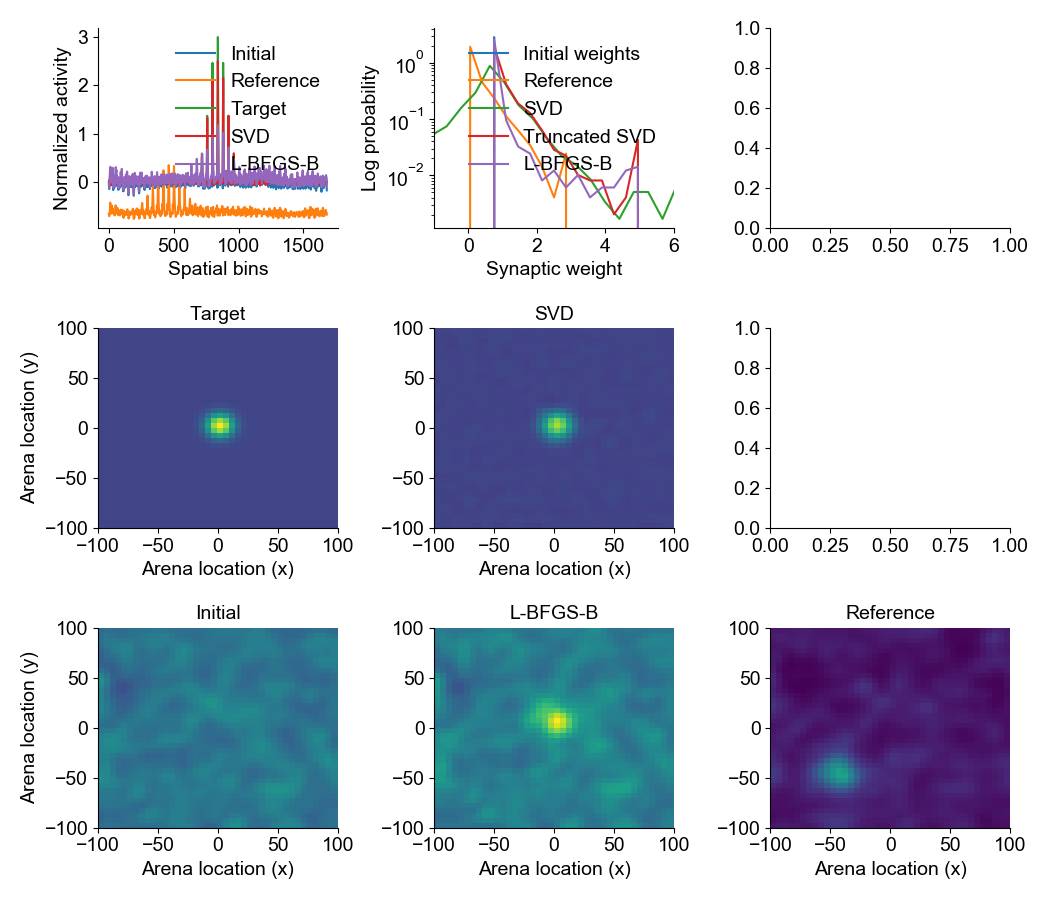

INFO:dentate./Users/milsteina/PycharmProjects/dentate/scripts/generate_DG_GC_normalized_delta_weights_single_gid_as_cell_attr.py:destination: GC; gid 0; generated Normalized Structured Delta Weights for 5016 synapses


In [2]:
%run scripts/generate_DG_GC_normalized_delta_weights_single_gid_as_cell_attr.py \
    -d GC -s MPP -s LPP \
    --config=config/Network_Clamp_GC_Exc_Sat_DD_S_0.yaml \
    --h5types-path=datasets/dentate_h5types.h5 \
    --reference-weights-path=datasets/Small_Scale/GC_tree_syns_connections_20200215.h5 \
    --reference-weights-namespace='Structured Weights A' --reference-weights-are-delta=False \
    --connections-path=datasets/Small_Scale/GC_tree_syns_connections_20200215.h5 \
    --input-features-path=datasets/Full_Scale_Control/DG_input_features_20190909_compressed.h5 \
    --arena-id=A --gid 0 --coordinates 0. 0. -v --interactive --dry-run --plot --optimize-method='L-BFGS-B'

In [3]:
locals().update(context())

In [4]:
initial_weight_dict=initial_weights_by_source_gid_dict
input_rate_map_dict=input_rate_maps_by_source_gid_dict
syn_count_dict=syn_count_by_source_gid_dict
reference_weight_dict=reference_weights_by_source_gid_dict
max_iter=100
target_amplitude=3.

In [5]:
scaled_target_map = target_map - np.min(target_map)
scaled_target_map /= np.max(scaled_target_map)
scaled_target_map *= target_amplitude

flat_scaled_target_map = scaled_target_map.ravel()
input_matrix = np.empty((len(input_rate_map_dict), len(flat_scaled_target_map)))
source_gid_array = np.empty(len(input_rate_map_dict))
syn_count_array = np.empty(len(input_rate_map_dict))
initial_weight_array = np.empty(len(input_rate_map_dict))
if reference_weight_dict is None:
    reference_weight_array = None
else:
    reference_weight_array = np.empty(len(input_rate_map_dict))
for i, source_gid in enumerate(input_rate_map_dict):
    source_gid_array[i] = source_gid
    this_syn_count = syn_count_dict[source_gid]
    input_matrix[i, :] = input_rate_map_dict[source_gid].ravel() * this_syn_count
    syn_count_array[i] = this_syn_count
    initial_weight_array[i] = initial_weight_dict[source_gid]
    if reference_weight_array is not None:
        reference_weight_array[i] = reference_weight_dict[source_gid]

mean_initial_weight = np.mean(initial_weight_array)
max_weight = mean_initial_weight + max_delta_weight
initial_background_map = initial_weight_array.dot(input_matrix)
scaling_factor = np.mean(initial_background_map)
if scaling_factor <= 0.:
    raise RuntimeError('generate_structured_delta_weights: initial weights must produce positive activation')
initial_background_map /= scaling_factor
initial_background_map -= 1.

scaled_input_matrix = np.divide(input_matrix, scaling_factor)
[U, s, Vh] = np.linalg.svd(scaled_input_matrix)
V = Vh.T
D = np.zeros_like(input_matrix)
beta = np.mean(s)  # Previously, beta was provided by user, but should depend on scale if data is not normalized
D[np.where(np.eye(*D.shape))] = s / (s ** 2. + beta ** 2.)
input_matrix_inv = V.dot(D.conj().T).dot(U.conj().T)
SVD_delta_weights = flat_scaled_target_map.dot(input_matrix_inv)
flat_SVD_map = SVD_delta_weights.dot(scaled_input_matrix)

num_bins = 20
edges = np.linspace(-1., max_weight + 1., num_bins + 1)
# bounds = (mean_initial_weight, max_weight)
bounds = (0., max_delta_weight)
initial_LS_delta_weights = np.maximum(np.minimum(SVD_delta_weights, bounds[1]), bounds[0])

if optimize_method == 'L-BFGS-B':
    result = minimize(get_activation_map_residual_mse, initial_LS_delta_weights,
                      args=(scaled_input_matrix, flat_scaled_target_map), method='L-BFGS-B',
                      bounds=[bounds] * len(initial_LS_delta_weights), options={'disp': verbose, 'maxiter': max_iter})
elif optimize_method == 'dogbox':
    result = least_squares(get_activation_map_residual_mse, initial_LS_delta_weights,
                           args=(scaled_input_matrix, flat_scaled_target_map), bounds=bounds, method='dogbox',
                           verbose=2 if verbose else 0, max_nfev=max_iter, ftol=5e-5)
else:
    raise RuntimeError('generate_structured_delta_weights: optimization method: %s not implemented' %
                       optimize_method)

LS_delta_weights = np.array(result.x)
scaled_LS_weights = LS_delta_weights / np.max(LS_delta_weights) * max_delta_weight + mean_initial_weight
flat_LS_map = scaled_LS_weights.dot(scaled_input_matrix) - 1.

<IPython.core.display.Javascript object>


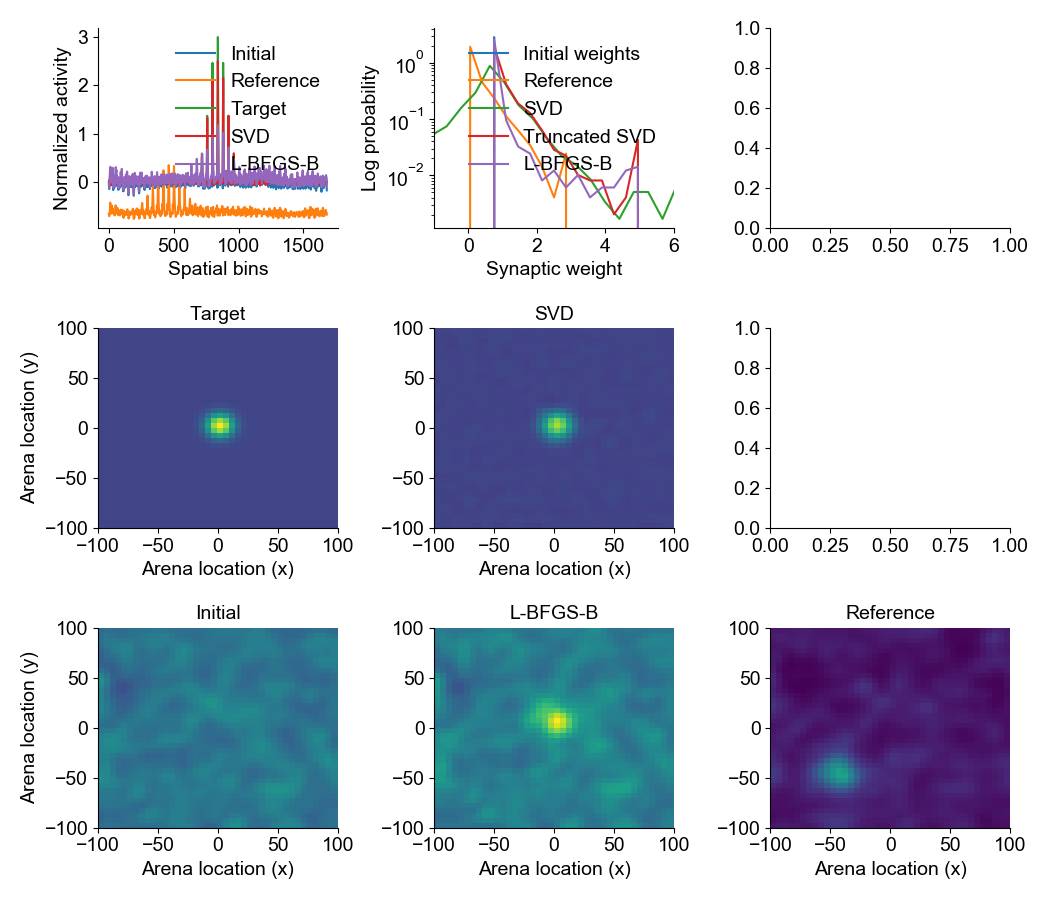

In [6]:
if arena_x is None or arena_y is None:
    raise RuntimeError('generate_structured_delta_weights: missing required arena coordinates for plotting')
import matplotlib.pyplot as plt
import matplotlib as mpl
from dentate.plot import clean_axes
default_font_size = mpl.rcParams['font.size']

min_vals = [np.min(flat_scaled_target_map), np.min(flat_SVD_map), np.min(flat_LS_map),
            np.min(initial_background_map)]
max_vals1 = [np.max(flat_scaled_target_map), np.max(flat_SVD_map)]
max_vals2 = [np.max(flat_LS_map), np.max(initial_background_map)]
if reference_weight_array is not None:
    fig, axes = plt.subplots(3, 3, figsize=(10.5, 9))
    if reference_weights_are_delta:
        reference_weights = reference_weight_array / np.max(reference_weight_array) * max_delta_weight + \
                            mean_initial_weight
    else:
        reference_weights = reference_weight_array
    flat_reference_map = reference_weights.dot(scaled_input_matrix) - 1.
    min_vals.append(np.min(flat_reference_map))
    max_vals2.append(np.max(flat_reference_map))
else:
    fig, axes = plt.subplots(3, 2, figsize=(7, 9))
vmin = min(min_vals)
vmax1 = max(max_vals1)
vmax2 = max(max_vals2)

axes[0][0].plot(range(len(flat_scaled_target_map)), initial_background_map, label='Initial')
if reference_weight_array is not None:
    axes[0][0].plot(range(len(flat_scaled_target_map)), flat_reference_map, label='Reference')
axes[0][0].plot(range(len(flat_scaled_target_map)), flat_scaled_target_map, label='Target')
axes[0][0].plot(range(len(flat_scaled_target_map)), flat_SVD_map, label='SVD')
axes[0][0].plot(range(len(flat_scaled_target_map)), flat_LS_map, label=optimize_method)
axes[0][0].set_ylabel('Normalized activity')
axes[0][0].set_xlabel('Spatial bins')
axes[0][0].legend(loc='best', frameon=False, framealpha=0.5, fontsize=default_font_size)

hist, _ = np.histogram(initial_weight_array, bins=edges, density=True)
axes[0][1].semilogy(edges[:-1], hist, label='Initial weights')
axes[0][1].set_xlim(-mean_initial_weight, max_delta_weight + 2. * mean_initial_weight)
axes[0][1].set_ylabel('Log probability')
axes[0][1].set_xlabel('Synaptic weight')
if reference_weight_array is not None:
    hist, _ = np.histogram(reference_weights, bins=edges, density=True)
    axes[0][1].semilogy(edges[:-1], hist, label='Reference')
hist, edges2 = np.histogram(np.add(SVD_delta_weights, mean_initial_weight), bins=2 * num_bins, density=True)
axes[0][1].semilogy(edges2[:-1], hist, label='SVD')
hist, _ = np.histogram(np.add(initial_LS_delta_weights, mean_initial_weight), bins=edges, density=True)
axes[0][1].semilogy(edges[:-1], hist, label='Truncated SVD')
hist, _ = np.histogram(scaled_LS_weights, bins=edges, density=True)
axes[0][1].semilogy(edges[:-1], hist, label=optimize_method)
axes[0][1].legend(loc='best', frameon=False, framealpha=0.5, fontsize=default_font_size)

axes[1][0].pcolormesh(arena_x, arena_y, flat_scaled_target_map.reshape(arena_x.shape), vmin=vmin,
                      vmax=vmax1)
axes[1][0].set_title('Target', fontsize=default_font_size)
axes[1][1].pcolormesh(arena_x, arena_y, flat_SVD_map.reshape(arena_x.shape), vmin=vmin, vmax=vmax1)
axes[1][1].set_title('SVD', fontsize=default_font_size)
axes[2][0].pcolormesh(arena_x, arena_y, initial_background_map.reshape(arena_x.shape), vmin=vmin, vmax=vmax2)
axes[2][0].set_title('Initial', fontsize=default_font_size)
axes[2][1].pcolormesh(arena_x, arena_y, flat_LS_map.reshape(arena_x.shape), vmin=vmin, vmax=vmax2)
axes[2][1].set_title(optimize_method, fontsize=default_font_size)
if reference_weight_array is not None:
    axes[2][2].pcolormesh(arena_x, arena_y, flat_reference_map.reshape(arena_x.shape), vmin=vmin, vmax=vmax2)
    axes[2][2].set_title('Reference', fontsize=default_font_size)
    axes[2][2].set_xlabel('Arena location (x)')
axes[1][0].set_ylabel('Arena location (y)')
axes[2][0].set_ylabel('Arena location (y)')
axes[1][0].set_xlabel('Arena location (x)')
axes[1][1].set_xlabel('Arena location (x)')
axes[2][0].set_xlabel('Arena location (x)')
axes[2][1].set_xlabel('Arena location (x)')
clean_axes(axes)
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
fig.show()

In [7]:
len(np.where(scaled_LS_weights > mean_initial_weight)[0]), len(np.where(reference_weights > mean_initial_weight)[0])

(188, 146)

In [9]:
len(np.where(scaled_LS_weights < mean_initial_weight)[0]), len(np.where(reference_weights < mean_initial_weight)[0])

(0, 1261)

In [8]:
np.mean(scaled_LS_weights[scaled_LS_weights > mean_initial_weight]), np.mean(reference_weights[reference_weights > mean_initial_weight])

(1.7547226243600662, 1.5983638175546306)

In [10]:
np.mean(scaled_LS_weights[scaled_LS_weights < mean_initial_weight]), np.mean(reference_weights[reference_weights < mean_initial_weight])

/Users/milsteina/anaconda2/envs/py3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/milsteina/anaconda2/envs/py3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(nan, 0.32602847435472504)